### 🥬 1. Setup Model

In [1]:
import torch, requests, math
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration, BitsAndBytesConfig

c:\Users\namth\anaconda3\envs\lung_caption_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W1006 16:19:35.518000 15952 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# ----------------------------
# 0) เตรียมอุปกรณ์
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [3]:
# ----------------------------
# 1) โหลดโมเดล + โปรเซสเซอร์
# ----------------------------

processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    trust_remote_code=True,
)

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    trust_remote_code=True,
    quantization_config=bnb_cfg,
    device_map={"": 0},                 # <<< บังคับลง GPU0 ทั้งโมเดล
    low_cpu_mem_usage=True,
    dtype=torch.bfloat16,         # ให้ตรงกับ compute_dtype ด้านบน
    output_attentions=True,
    output_hidden_states=True
    # ไม่ใส่ offload_folder
).eval().cuda()

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.81s/it]


### 🥬 2. Generate output

In [4]:
# ----------------------------
# 2) โหลดภาพทดสอบ + คำสั่ง
# ----------------------------

file_path = "./progress_picture/2nd/qwen/1.jpeg"
image = Image.open(file_path).convert("RGB").resize((224, 224))

prompt_text = (
    "Describe the image in detail. Focus on the objects, colors, and spatial arrangement. "
    "Mention what is happening and where each element is located."
)

messages = [{
    "role": "user",
    "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": prompt_text}
    ],
}]

In [9]:
# ----------------------------
# 3) Inference ให้เห็นผลข้อความจริง
# ----------------------------

chat_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# สร้าง batch inputs (ทั้งข้อความ+ภาพ) สำหรับ generate
inputs = processor(
    text=[chat_text],
    images=[image],
    videos=None,
    padding=True,
    return_tensors="pt",
)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.inference_mode():
    gen_ids = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=False,        # deterministic
        use_cache=True,
    )

# ตัด prompt ออก เหลือเฉพาะที่โมเดลพูดต่อ
trimmed = [out[len(inp):] for inp, out in zip(inputs["input_ids"], gen_ids)]
texts = processor.batch_decode(trimmed, skip_special_tokens=True)
print("Model output:", texts[0].strip())

Model output: The image is an X-ray of a hand, specifically focusing on the wrist and fingers. The X-ray is labeled with "R" indicating it is a right hand X-ray. The X-ray shows the bones of the hand, including the metacarpals (the long bones at the base of the fingers), the phalanges (the bones of the fingers), and the carpal bones (the small bones forming the wrist).

The bones appear to be intact without any obvious fractures or dislocations. The skin around the hand appears normal, with no signs of swelling or bruising.

The X-ray is taken from a frontal view, which means the hand is facing the camera. The X-ray film is black, and the bones are white due to the way X-rays are absorbed by different materials. The background is black, which helps to highlight the bones clearly.

There are no other objects or elements present in the image besides the hand and the X-ray film. The spatial arrangement is straightforward, with the hand centered in the frame and the X-ray film covering the

### 🥬 3. Visualize Feature Map BUT Attention layer

In [10]:
# ---------- Utilities to locate visual/text token spans for Qwen2.5-VL (multi <|image_pad|>) ----------
import torch

def get_special_token_ids(processor):
    tok = processor.tokenizer
    return {
        "vision_start": tok.convert_tokens_to_ids("<|vision_start|>"),
        "image_pad":    tok.convert_tokens_to_ids("<|image_pad|>"),
        "vision_end":   tok.convert_tokens_to_ids("<|vision_end|>"),
        "im_start":     tok.convert_tokens_to_ids("<|im_start|>"),
        "im_end":       tok.convert_tokens_to_ids("<|im_end|>"),
    }

@torch.no_grad()
def locate_visual_spans_multi(inputs, out_attentions, processor):
    """
    รองรับหลาย <|image_pad|> (เช่น 64 ตัว) ใน sequence เดียว
    คืนค่า:
        - spans: [(start_img, end_img), ...] ต่อ placeholder ตามลำดับซ้าย->ขวา หลัง forward
        - V_per_pad: จำนวนโทเคนภาพจริง/placeholder (คาดว่าเท่ากันทุกตัว)
        - pre_len, post_len, idx_vpads (ดัชนีก่อน forward)
        - groups: รายการกลุ่มต่อบล็อกภาพ (คอนทiguous pads) เช่น [(0,63)] สำหรับ 64 ตัวติดกัน
    หมายเหตุ: สมมติ batch=1 และภาพเดียวที่ถูกแตกเป็นหลาย placeholder
    """
    assert "input_ids" in inputs, "inputs must contain input_ids"
    input_ids = inputs["input_ids"][0]                  # (pre_len,)
    pre_len = input_ids.shape[0]
    post_len = out_attentions[0].shape[-1]              # (B, H, T, T) -> T

    ids = get_special_token_ids(processor)
    idx_vpads = (input_ids == ids["image_pad"]).nonzero(as_tuple=True)[0].tolist()
    if len(idx_vpads) == 0:
        raise ValueError("No <|image_pad|> found in input_ids.")

    N = len(idx_vpads)                                   # จำนวน placeholders
    # โทเคนภาพจริงรวมทั้งหมดหลัง forward:
    V_total = post_len - pre_len + N                     # แทนแต่ละ pad (1 โทเคนก่อน forward) ด้วย V_per_pad
    if V_total <= 0:
        raise ValueError(f"Invalid V_total computed: {V_total}")

    # สมมติว่าแต่ละ placeholder ขยายเป็นจำนวนโทเคนเท่ากัน:
    V_per_pad, remainder = divmod(V_total, N)

    # คำนวณ start/end ของแต่ละ placeholder หลัง forward
    # หลักการ: pad ลำดับ k (0-based) จะถูกเลื่อนขวาไปด้วย (V_per_pad-1) ต่อ pad ที่มาก่อน
    # ถ้ามี remainder>0 ให้แจก +1 กับ pads แรก ๆ ตามลำดับเพื่อให้ผลรวมตรง post_len
    spans = []
    extra_prefix = 0
    for k, ppre in enumerate(sorted(idx_vpads)):
        extra = 1 if k < remainder else 0                # แจกส่วนเกินทีละ 1 ไปทางซ้ายก่อน
        # จำนวนที่ขยายก่อนหน้ารวม:
        expanded_before = k * (V_per_pad - 1) + min(k, remainder)  # เพราะ k ตัวแรกได้ +1 เพิ่ม
        start_k = ppre + expanded_before
        end_k   = start_k + (V_per_pad + extra) - 1
        spans.append((start_k, end_k))

    # จัดกลุ่ม placeholder ที่ติดกัน (เผื่อคุณอยากขีดเป็นบล็อกเดียว)
    groups = []
    if idx_vpads:
        run_start = 0
        for i in range(1, N):
            if idx_vpads[i] != idx_vpads[i-1] + 1:
                groups.append((run_start, i-1))
                run_start = i
        groups.append((run_start, N-1))

    return {
        "spans": spans,                   # รายการช่วงภาพจริง ต่อ placeholder หลัง forward
        "V_per_pad": V_per_pad,
        "remainder": remainder,
        "pre_len": pre_len,
        "post_len": post_len,
        "idx_vpads": idx_vpads,          # ดัชนี <|image_pad|> ก่อน forward
        "groups": groups,                 # กลุ่มต่อบล็อกภาพ: index ใน idx_vpads เช่น [(0,63)]
        "N_pads": N,
        "V_total": V_total,
    }

def annotate_axes_with_span(ax, start_img, end_img, color='r', lw=1.2):
    ax.axvline(start_img - 0.5, linewidth=lw, color=color)
    ax.axvline(end_img   + 0.5, linewidth=lw, color=color)
    ax.axhline(start_img - 0.5, linewidth=lw, color=color)
    ax.axhline(end_img   + 0.5, linewidth=lw, color=color)

In [ ]:
# ----------------------------
# 4) ดึง Visual Attention จาก vlm
#    - ใช้พิกเซลจาก image_processor โดยตรง
#    - ขอ output_attentions=True เพื่อดึงแผนที่ attention ทุกเลเยอร์
# ----------------------------

with torch.inference_mode():
    out = model(
        **inputs,
        output_attentions=True,
        return_dict=True,
        use_cache=False
    )

attentions = out.attentions

# ----------------------------
# คำนวณช่วงโทเคนภาพ/ข้อความเพื่ออ้างอิงตอน plot
# ----------------------------
span_info = locate_visual_spans_multi(inputs, attentions, processor)
print(f"[DEBUG] pre={span_info['pre_len']} post={span_info['post_len']} "
        f"N_pads={span_info['N_pads']} V_total={span_info['V_total']} "
        f"V_per_pad≈{span_info['V_per_pad']} remainder={span_info['remainder']}")

# ตัวอย่าง spans 3 ตัวแรก
print("[DEBUG] first 3 spans:", span_info["spans"][:3])

# Var
layer_idx_list = [0, 15, 35]

[DEBUG] pre=141 post=141 N_pads=64 V_total=64 V_per_pad≈1 remainder=0
[DEBUG] first 3 spans: [(15, 15), (16, 16), (17, 17)]


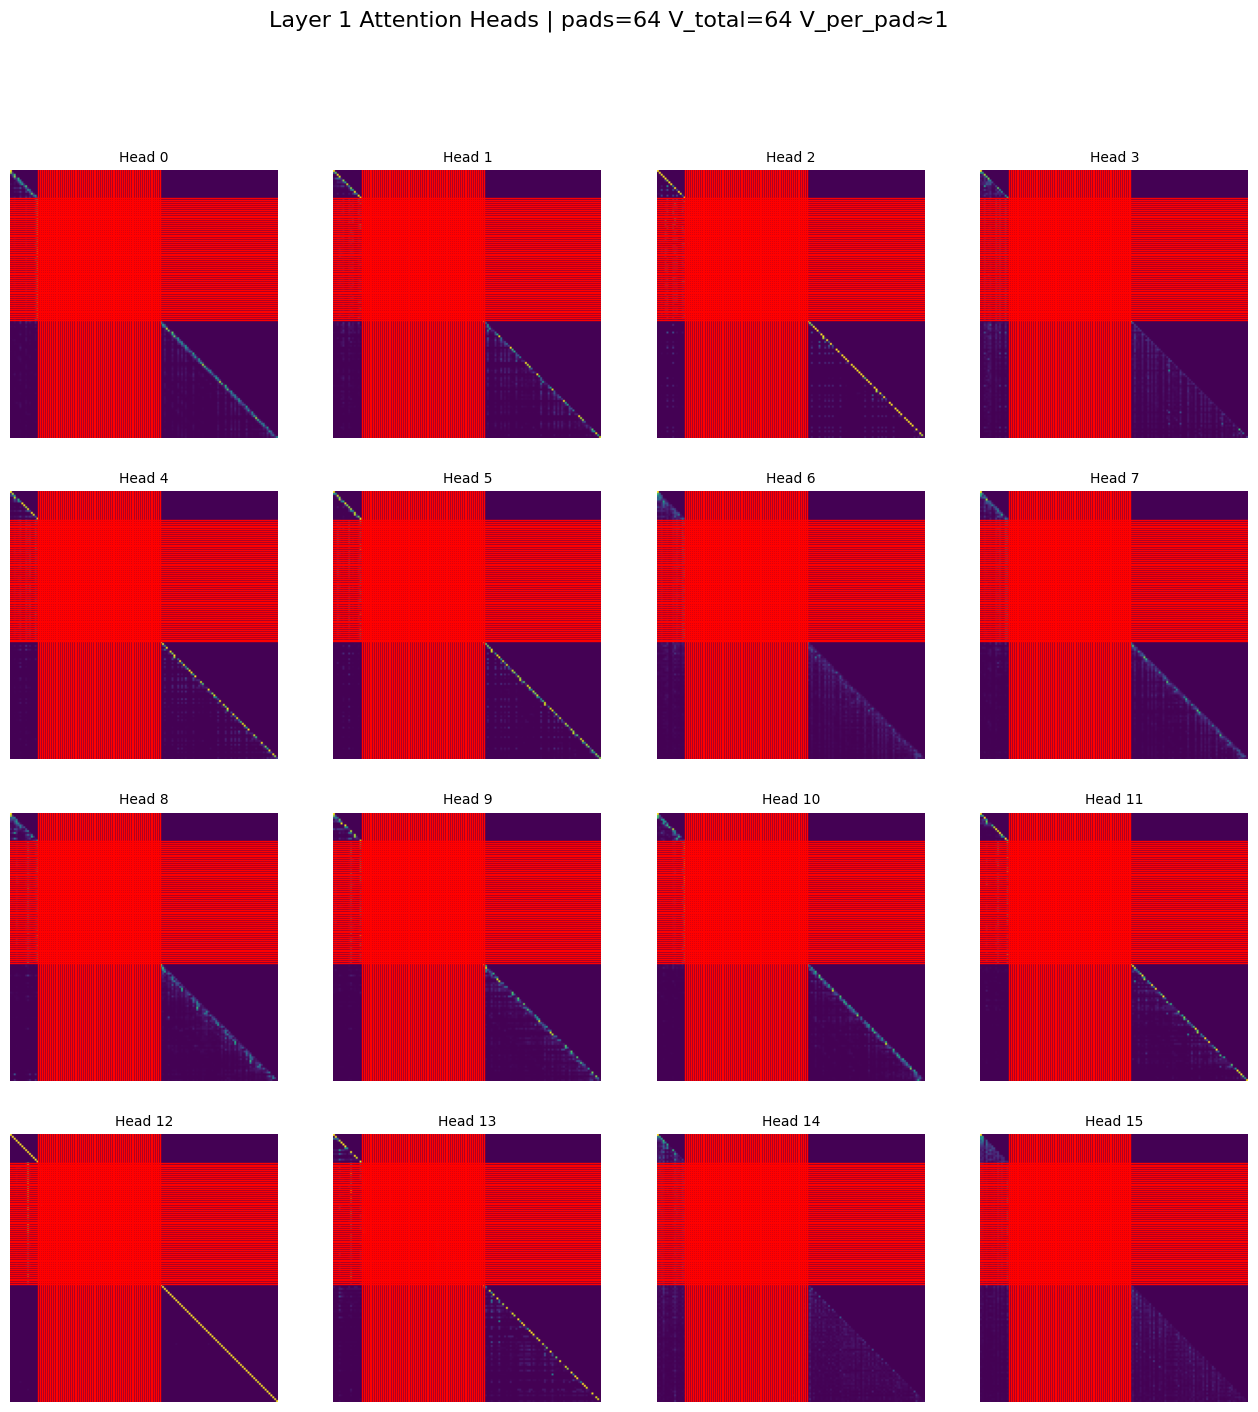

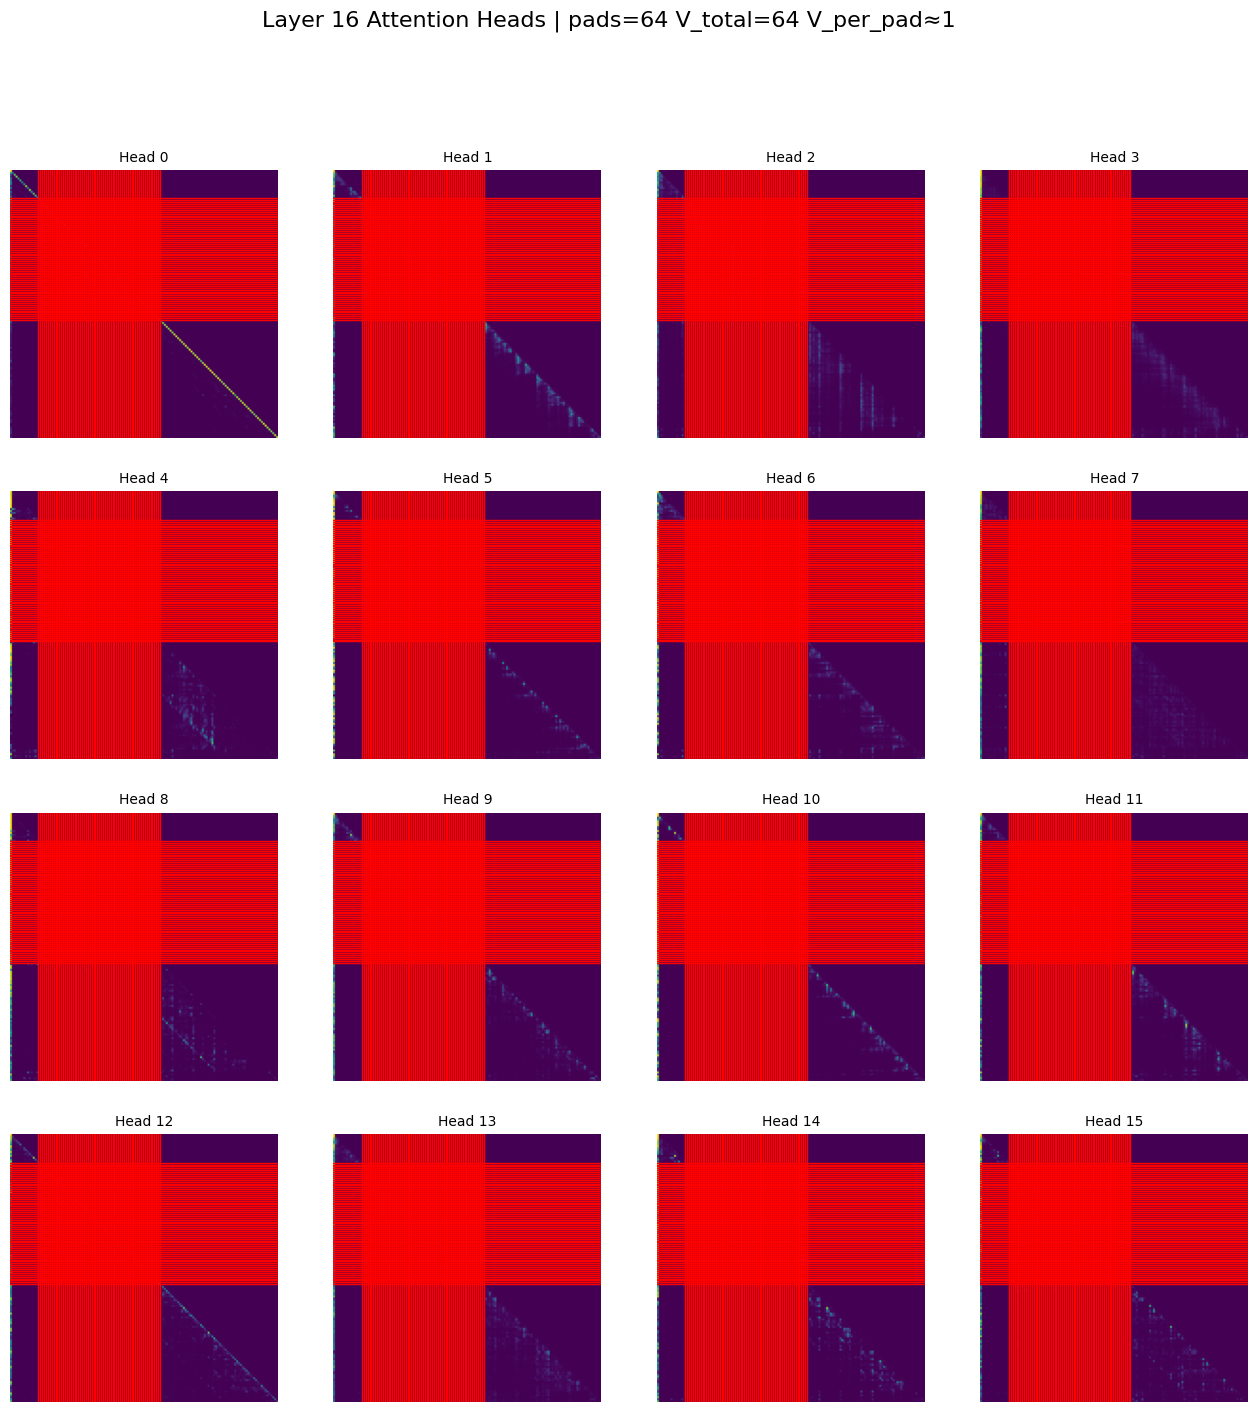

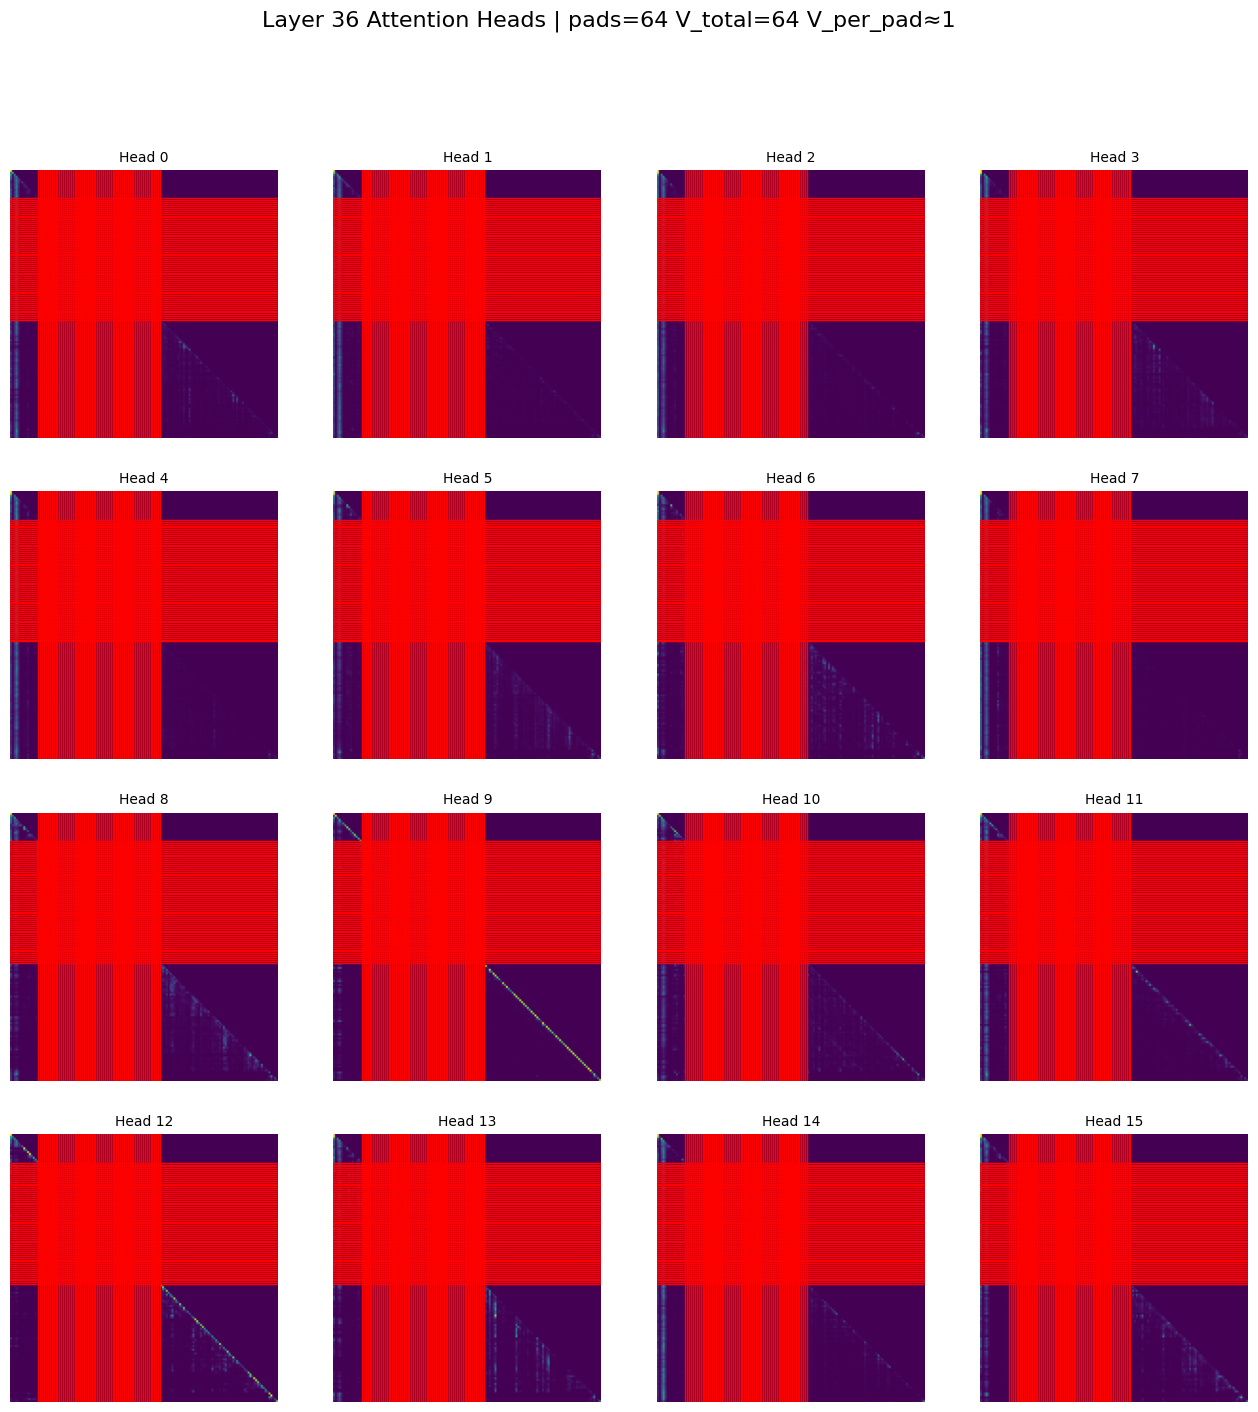

In [12]:
def visualize_attention_layer(attentions, layer_idx: int, nrows: int = 4, ncols: int = 4, span_info=None):
    layer = attentions[layer_idx]   # (batch, heads, T, T)
    batch0 = layer[0]

    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i < batch0.shape[0]:
            attn_head = batch0[i].detach().to("cpu", dtype=torch.float32).numpy()
            ax.imshow(attn_head)

            # ขีดกรอบช่วงภาพจริงทั้งหมด
            if span_info is not None:
                for (s, e) in span_info["spans"]:
                    annotate_axes_with_span(ax, s, e, color='r', lw=1.0)

            ax.set_title(f"Head {i}", fontsize=10)
        ax.axis("off")

    ttl = f"Layer {layer_idx + 1} Attention Heads"
    if span_info is not None:
        ttl += f" | pads={span_info['N_pads']} V_total={span_info['V_total']} V_per_pad≈{span_info['V_per_pad']}"
    plt.suptitle(ttl, fontsize=16)
    plt.savefig(f"Attention Heads Layer {layer_idx + 1}.png", dpi=300, bbox_inches="tight")
    plt.show()

for i in [0, 15, 35]:
    visualize_attention_layer(attentions, i, span_info=span_info)

ความยาวโทเคนทั้งหมด

In [13]:
post_len = attentions[0].shape[-1]      # ความยาวแกน T ของ attention หลัง forward
pre_len  = inputs["input_ids"].shape[1] # ความยาวอินพุตก่อน forward
print("pre_len:", pre_len, "post_len:", post_len)

pre_len: 141 post_len: 141


span_info ไม่ใช่ค่าว่าง แต่เป็น “พจนานุกรมของตัวคั่น/ช่วง” ที่เราคำนวณไว้เพื่อรู้ว่า ช่วงใดคือโทเคนภาพ (หลัง forward) และช่วงที่เหลือคือ โทเคนข้อความ คุณใช้มันเพื่อขีดเส้นแบ่งบนฮีตแมป และเพื่อสร้าง mask แยกภาพ/ข้อความได้

In [14]:
print(span_info["spans"][:3])

[(15, 15), (16, 16), (17, 17)]


In [16]:
start_indices = [s for (s, e) in span_info["spans"]]
print(start_indices[0])
print(start_indices[-1])

15
78


สร้าง mask แยก “ภาพ” กับ “ข้อความ” ใน post space

In [17]:
is_visual = np.zeros(post_len, dtype=bool)
for s, e in span_info["spans"]:
    is_visual[s:e+1] = True

# ข้อความ = ไม่ใช่ภาพ
is_text = ~is_visual

print(is_visual)

[False False False False False False False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]


ถอดรหัสข้อความจากช่วง index ใน post space

In [18]:
def build_post2pre_index_map(span_info, pre_len, post_len):
    """
    คืนอาเรย์ความยาว post_len ที่ชี้ไปยัง index ก่อน forward (pre index)
    สำหรับช่องที่เป็นโทเคนภาพ (post) จะให้ค่า -1 (ไม่มี pre id ให้ decode)
    """
    post2pre = np.full(post_len, -1, dtype=int)

    # เตรียมข้อมูลช่วย: ตำแหน่ง <|image_pad|> ก่อน forward (เรียงจากซ้ายไปขวา)
    pads_pre = sorted(span_info["idx_vpads"])              # ความยาว = N_pads
    spans = span_info["spans"]                             # รายการ (start_post, end_post) ต่อ pad
    # ทำ pointer เดินไปตามลำดับ pre/post
    # 1) mark ช่วงภาพใน post เป็น -1 (ไม่มี pre id)
    for (s, e) in spans:
        # ทั้งช่วงภาพไม่มี pre id โดยนิยาม (ถูก inject)
        pass  # post2pre[s:e+1] คงเป็น -1 อยู่แล้ว

    # 2) เติม mapping ให้โทเคน "ข้อความ" โดยเลื่อนตามจำนวนขยายก่อนหน้า
    # สร้าง offset function: จำนวนโทเคนภาพที่ถูก “สอดแทรก” ก่อนตำแหน่ง pre ที่กำหนด
    # (ใช้สูตรเดียวกับที่คำนวณ spans)
    # เพื่อความง่าย เราจะเดิน pre_idx จาก 0..pre_len-1 แล้วคำนวณ post_idx ที่มันไปอยู่
    V_per_pad = span_info["V_per_pad"]
    remainder = span_info["remainder"]     # pads แรก ๆ ที่ได้ +1
    pads_set = set(pads_pre)

    def expanded_before(k):  # k = ลำดับ pad (0-based) ก่อนหน้า
        return k * (V_per_pad - 1) + min(k, remainder)

    # สร้าง mapping pre→post
    pad_order = {p: i for i, p in enumerate(pads_pre)}  # pre_index ของ pad → ลำดับ pad
    extra_shift = 0
    post_cursor = 0
    pre_cursor = 0
    while pre_cursor < pre_len and post_cursor < post_len:
        if pre_cursor in pads_set:
            # เจอ pad ณ pre_cursor: ข้ามมัน (เพราะจะถูกแทนด้วยภาพใน post)
            k = pad_order[pre_cursor]
            # กระโดด post_cursor ไปท้ายช่วงภาพของ pad นี้
            s, e = spans[k]
            post_cursor = e + 1
            pre_cursor += 1
        else:
            # โทเคนข้อความ: หา post index ที่สอดคล้อง
            # นับจำนวน pad ที่อยู่ทางซ้ายของ pre_cursor
            # คือจำนวน p ใน pads_pre ที่ < pre_cursor
            k_left = np.searchsorted(pads_pre, pre_cursor, side="left")
            shift = expanded_before(k_left)  # จำนวนโทเคนเพิ่มจากภาพที่ขยายไปแล้ว
            post_idx = pre_cursor + shift
            if 0 <= post_idx < post_len and post2pre[post_idx] == -1:
                post2pre[post_idx] = pre_cursor
            pre_cursor += 1
            # ไม่ต้องขยับ post_cursor เพราะเราจัดการแบบคำนวณตำแหน่งโดยตรง

    return post2pre

post2pre = build_post2pre_index_map(span_info, pre_len, post_len)

In [19]:
post2pre

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140])

In [20]:
from transformers import PreTrainedTokenizerBase

tok = processor.tokenizer  # type: PreTrainedTokenizerBase

def decode_text_from_post_indices(post_indices, post2pre, inputs, tokenizer, skip_special=True):
    pre_indices = [post2pre[i] for i in post_indices if 0 <= post2pre[i] < inputs["input_ids"].shape[1]]
    if not pre_indices:
        return ""
    ids = inputs["input_ids"][0, pre_indices].tolist()
    return tokenizer.decode(ids, skip_special_tokens=skip_special)

# ตัวอย่าง: decode ข้อความ "ก่อนช่วงภาพแรก" (ถ้ามี)
text_left = None
first_span = min(span_info["spans"], key=lambda x: x[0])
if first_span[0] > 0:
    post_idx_range = list(range(0, first_span[0]))                       # [0 .. start_img-1]
    post_idx_range = [i for i in post_idx_range if post2pre[i] != -1]    # ตัดภาพทิ้ง
    text_left = decode_text_from_post_indices(post_idx_range, post2pre, inputs, tok)
    print("Decoded (left of first image):", text_left)

# หรือ decode “ทั้งหมดที่เป็นข้อความ” ใน post space
all_text_post_idx = [i for i in range(post_len) if post2pre[i] != -1]
decoded_all = decode_text_from_post_indices(all_text_post_idx, post2pre, inputs, tok)
print("Decoded (all text tokens from prompt):", decoded_all)

Decoded (left of first image): system
You are a helpful assistant.
user

Decoded (all text tokens from prompt): system
You are a helpful assistant.
user
Describe the image in detail. Focus on the objects, colors, and spatial arrangement. Mention what is happening and where each element is located.Describe the image in detail. Focus on the objects, colors, and spatial arrangement. Mention what is happening and where each element is located.
assistant



In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

def collect_image_token_indices(span_info):
    # รวมช่วงภาพทั้งหมด (หลัง forward) ให้เป็นลิสต์ index (post-space)
    img_idx = []
    for s, e in span_info["spans"]:
        img_idx.extend(list(range(s, e+1)))
    return np.array(img_idx, dtype=int)

def collect_text_token_mask(span_info, post_len):
    is_visual = np.zeros(post_len, dtype=bool)
    for s, e in span_info["spans"]:
        is_visual[s:e+1] = True
    return ~is_visual, is_visual

def infer_grid_hw(n_img_tokens, img_w, img_h):
    """
    เดา (grid_h, grid_w) จากจำนวนโทเคนภาพและอัตราส่วนภาพ:
        - หาแฟกเตอร์ (h,w) ที่ h*w = n_img_tokens
        - เลือกคู่ที่ ratio h/w ใกล้กับ img_h/img_w ที่สุด
    ถ้าหาแฟกเตอร์พอดีไม่ได้ (กรณีโทเคนถูก pad/จัดรูปแปลก) จะเลือกคู่ที่ใกล้สุดจากตัวหารทั้งชุด
    """
    target_ratio = img_h / max(1e-6, img_w)
    best = None
    for h in range(1, int(np.sqrt(n_img_tokens)) + 1):
        if n_img_tokens % h == 0:
            w = n_img_tokens // h
            r = h / max(1e-6, w)
            score = abs(np.log((r+1e-12)/(target_ratio+1e-12)))
            if (best is None) or (score < best[0]):
                best = (score, h, w)
            # ลองสลับ (h,w) เผื่อ ratio อีกด้านใกล้กว่า
            r2 = w / max(1e-6, h)
            score2 = abs(np.log((r2+1e-12)/(target_ratio+1e-12)))
            if score2 < best[0]:
                best = (score2, w, h)
    if best is None:
        # fallback: สี่เหลี่ยมจัตุรัส
        side = int(np.sqrt(n_img_tokens))
        return side, max(1, n_img_tokens // max(1, side))
    _, gh, gw = best
    return gh, gw

def normalize_01(x):
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    return (x - mn) / (mx - mn + 1e-6)

def overlay_heatmap_on_image(image_pil, heat_2d, cmap="jet", alpha=0.5, blur=2):
    heat_uint8 = (normalize_01(heat_2d) * 255).astype(np.uint8)
    att_map = Image.fromarray(heat_uint8).resize(image_pil.size, Image.BICUBIC)
    if blur and blur > 0:
        att_map = att_map.filter(ImageFilter.GaussianBlur(blur))
    plt.imshow(image_pil)
    plt.imshow(att_map, cmap=cmap, alpha=alpha)
    plt.axis("off")


LLM (Qwen2.5-VL) style — ไม่มี [CLS] จริงในลำดับมัลติโมดัล → เราสร้าง “CLS-like” โดย เฉลี่ย attention ของโทเคนข้อความทั้งหมด → ไปยังโทเคนภาพ แล้วรีเชปเป็นกริดและ overlay

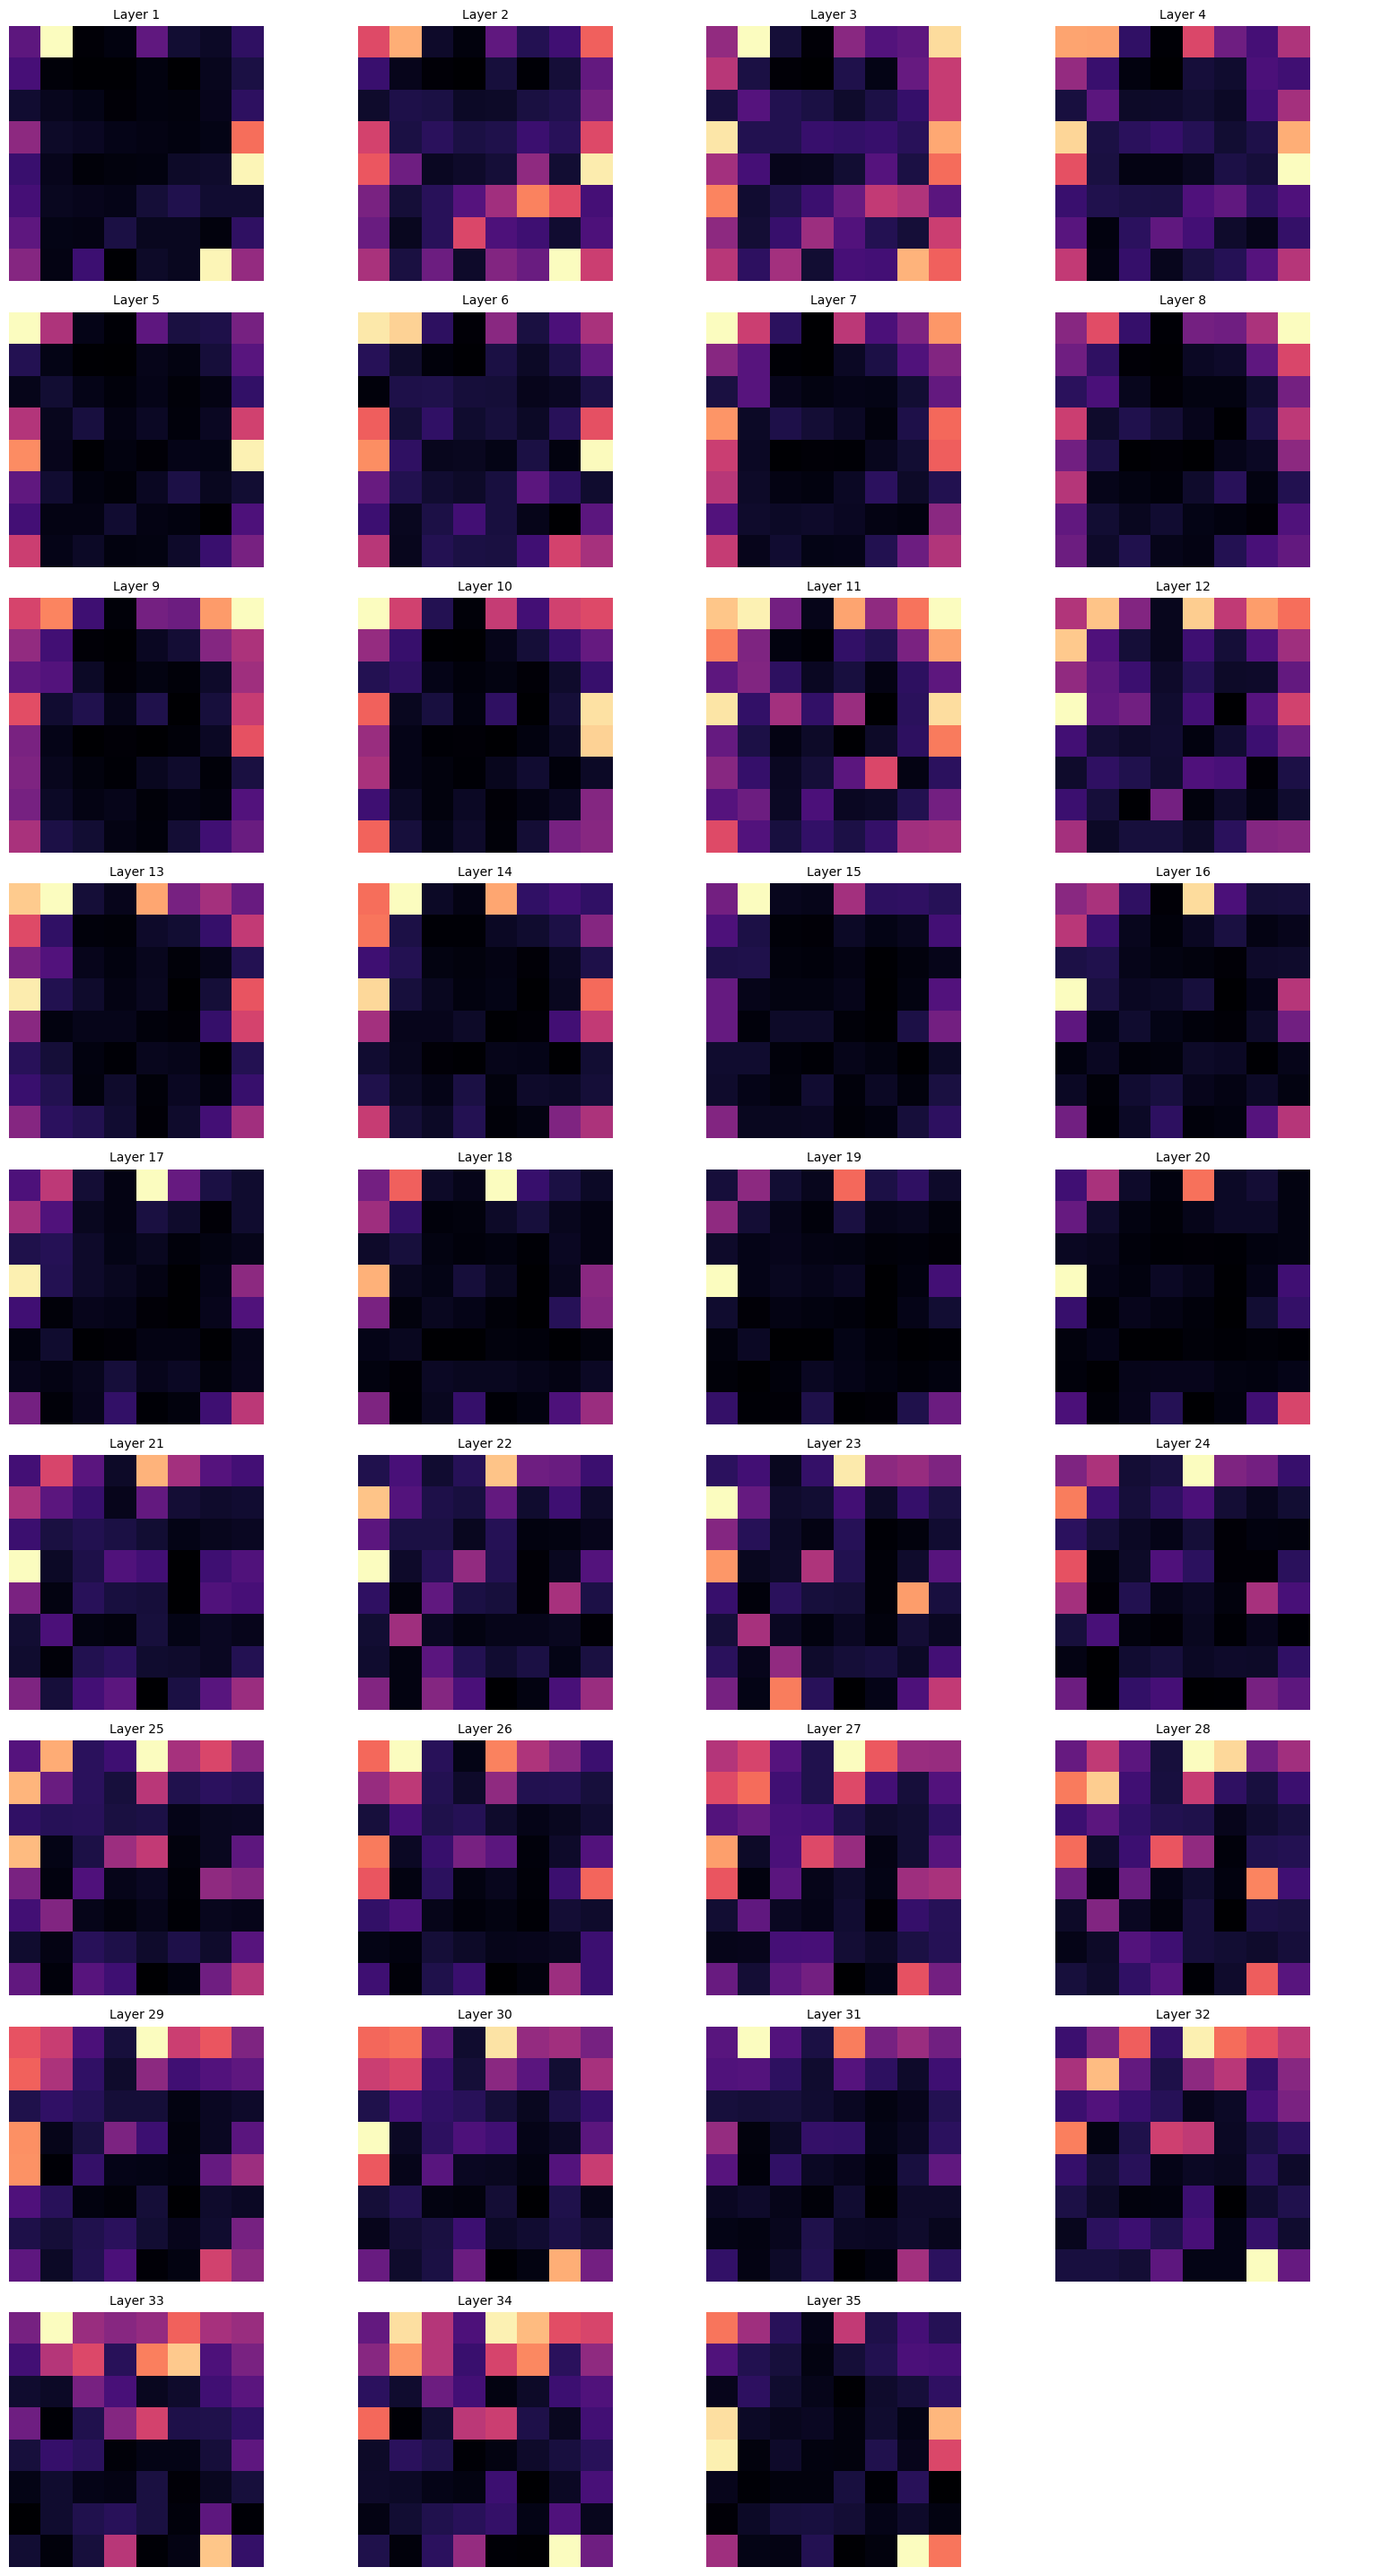

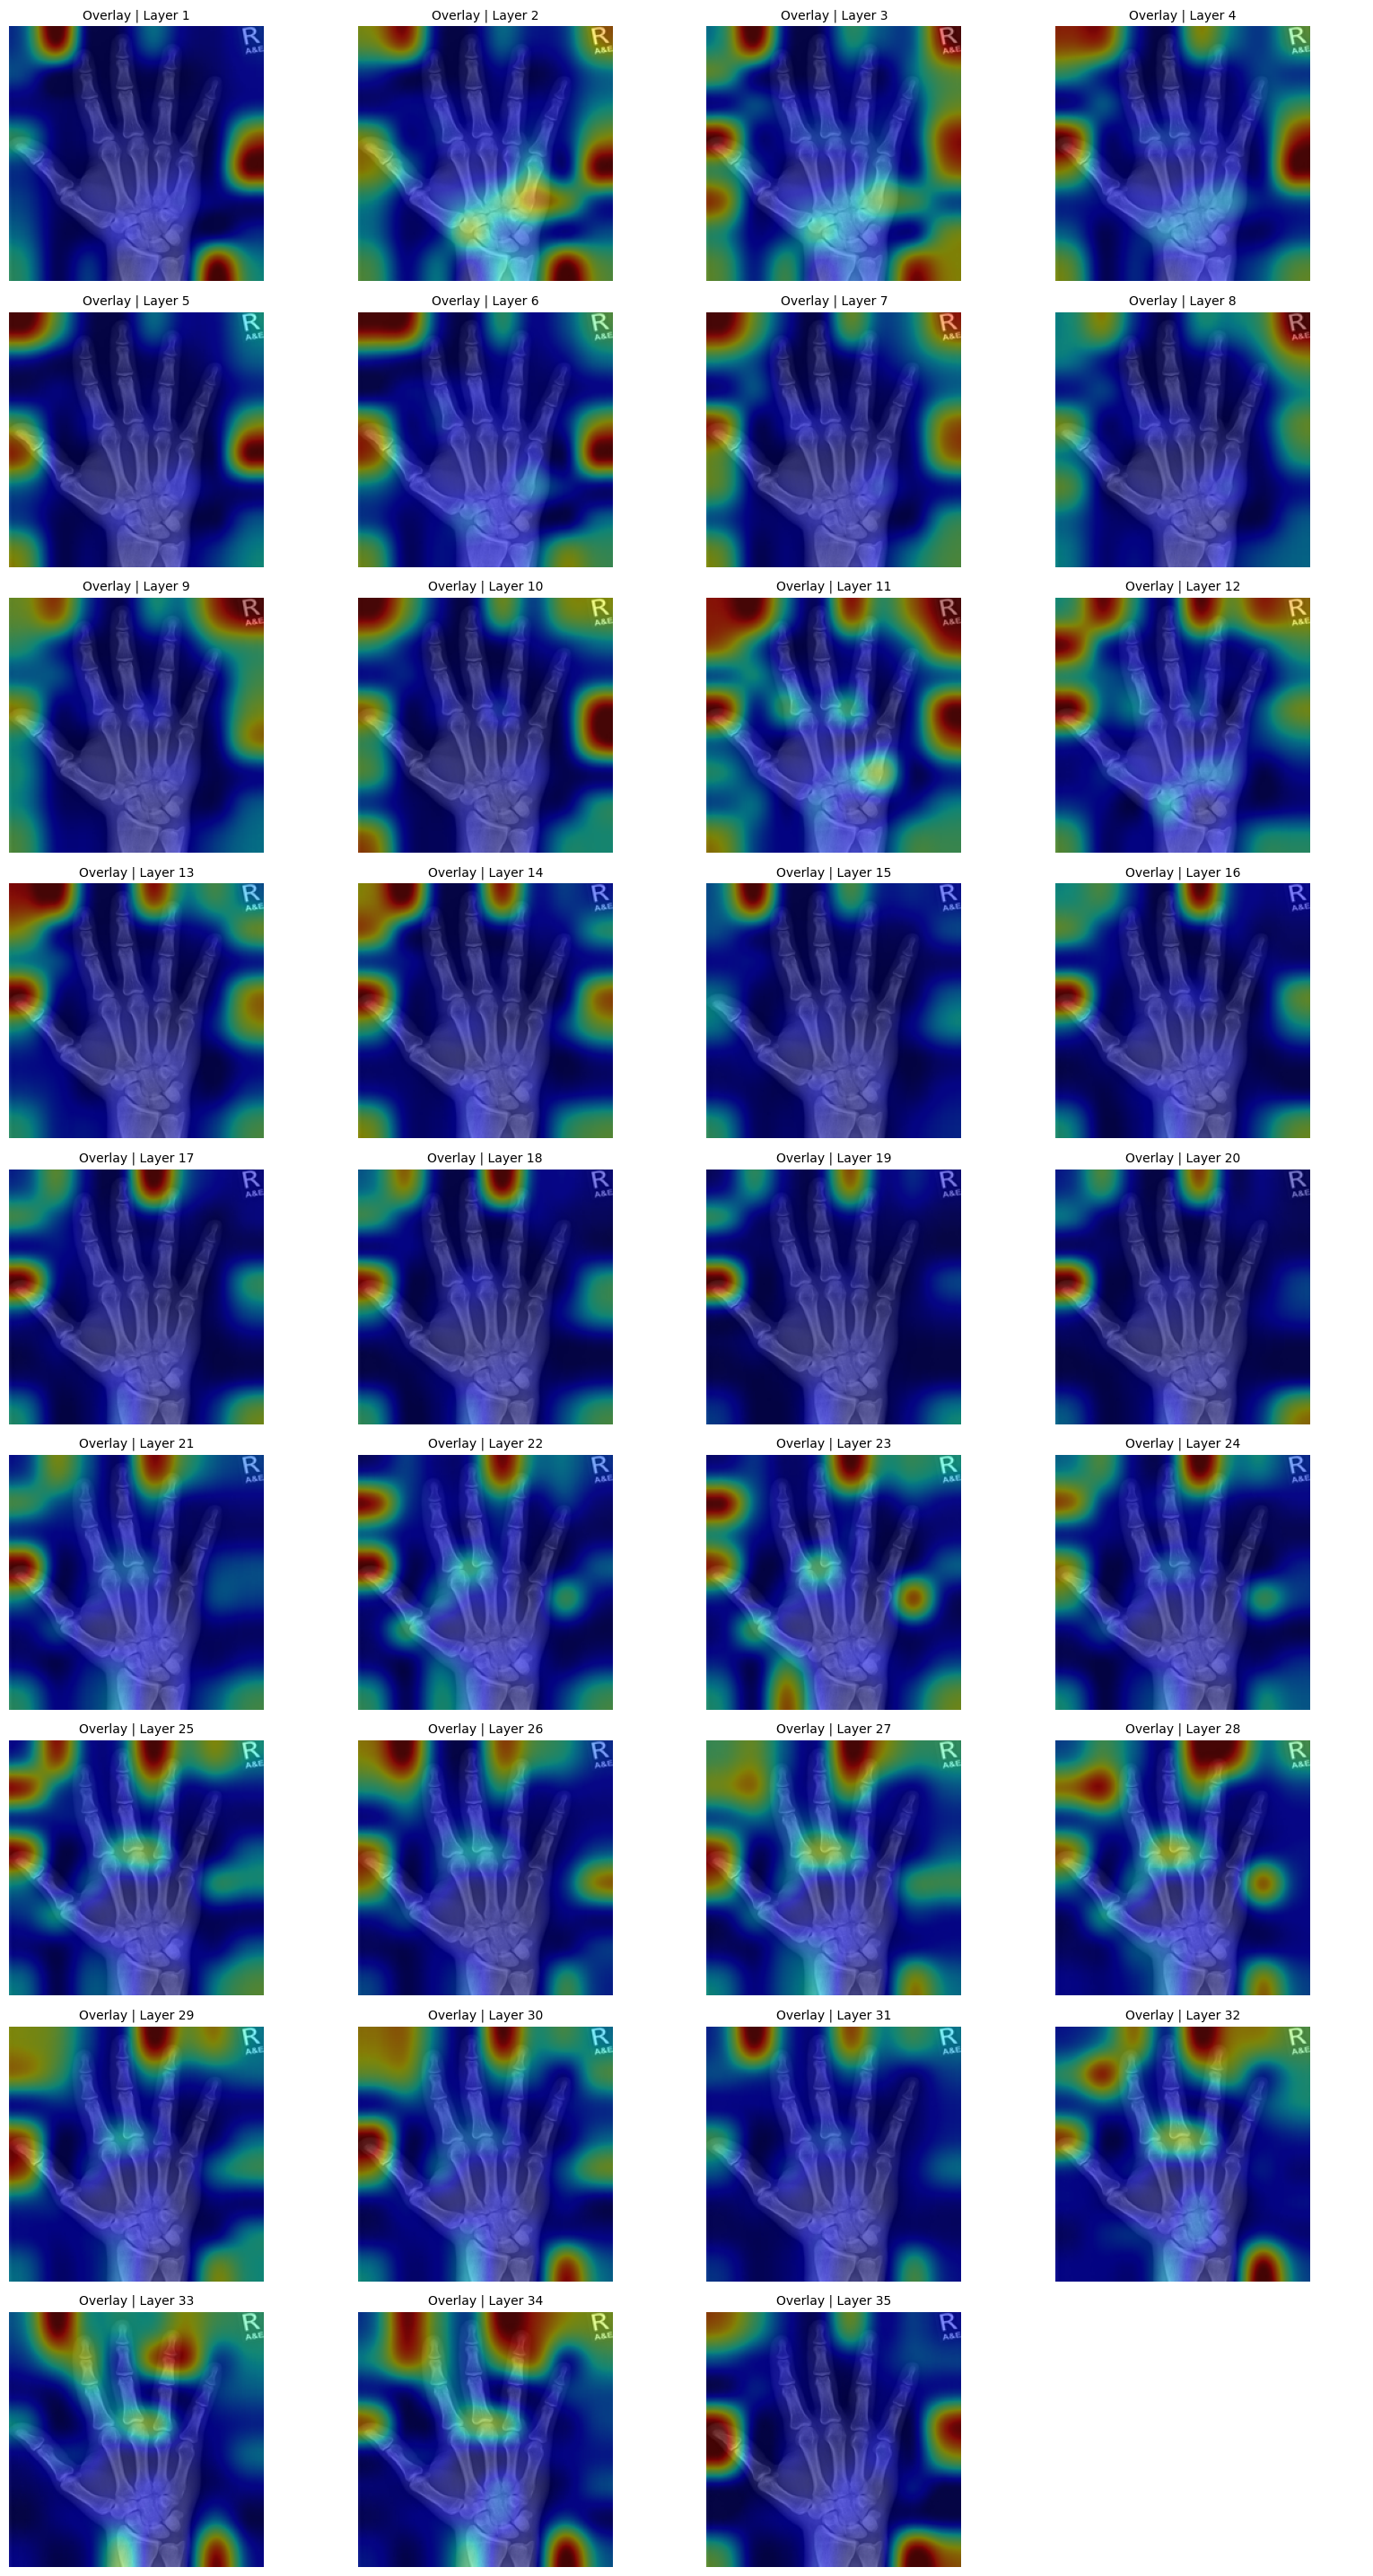

In [22]:

# ==========================================================
# 🧠 TEXT → IMAGE ATTENTION VISUALIZATION (Qwen2.5-VL Style)
# ----------------------------------------------------------
# แสดง Attention เฉลี่ยจากโทเคนข้อความทั้งหมด → โทเคนภาพ
# โดยสร้าง heatmap ของแต่ละ layer และจัดรวมเป็นตาราง (4 ภาพต่อแถว)
# จากนั้น overlay ลงบนภาพจริงเพื่อดูจุดที่โมเดล “สนใจ” บนภาพ
# ==========================================================

import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import torch

# ----------------------------------------------------------
# 🔹 เตรียม index / mask สำหรับ text และ image token
# ----------------------------------------------------------
post_len = attentions[0].shape[-1]  # ความยาว sequence หลัง forward
is_text, is_visual = collect_text_token_mask(span_info, post_len)
text_idx  = np.where(is_text)[0]
image_idx = collect_image_token_indices(span_info)

# ----------------------------------------------------------
# 🔹 ฟังก์ชันคำนวณ Text→Image Rollout ต่อ Layer
# ----------------------------------------------------------
def text_to_image_rollout(attentions, layer_idx: int):
    """
    สรุป attention จากข้อความทั้งหมด → ภาพ
    1. เฉลี่ยทุกหัว (H) → (T, T)
    2. เพิ่ม self-connection (I) เพื่อคง self-loop
    3. Normalize ให้ sum ต่อแถว = 1
    4. เฉลี่ยเฉพาะ query=ข้อความ → ได้เวกเตอร์ขนาดเท่าจำนวนโทเคนทั้งหมด
    5. เลือกเฉพาะ key=โทเคนภาพ → attention ต่อภาพแต่ละตำแหน่ง
    """
    attn = attentions[layer_idx][0].mean(0)     # (T, T)
    T = attn.shape[0]
    I = torch.eye(T, dtype=attn.dtype, device=attn.device)
    A = attn + I
    A = A / (A.sum(dim=-1, keepdim=True) + 1e-6)
    vec_all_keys = A[text_idx].mean(dim=0)      # (T,)
    vec_img = vec_all_keys[image_idx]           # (N_img,)
    return vec_img.detach().cpu().float().numpy()

# ----------------------------------------------------------
# 🔹 เตรียม Heatmap สำหรับทุก Layer
# ----------------------------------------------------------
layer_idx_list = [i for i in range(35)]  # 35 layers
img_w, img_h = image.size
n_img_tokens = len(image_idx)
grid_h, grid_w = infer_grid_hw(n_img_tokens, img_w, img_h)

heats = []
for i in layer_idx_list:
    vec_img = text_to_image_rollout(attentions, i)  # (N_img,)
    heat = vec_img.reshape(grid_h, grid_w)
    heat = normalize_01(heat)
    heats.append((i, heat))

# ----------------------------------------------------------
# 🔹 วาดรวม Heatmap ของทุก Layer (4 ภาพต่อแถว)
# ----------------------------------------------------------
ncols = 4
nrows = math.ceil(len(heats) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.2*nrows))
axs = axs.flatten()

vmin, vmax = 0.0, 1.0  # scale สีเดียวกันทุกภาพ

for ax, (i, heat) in zip(axs, heats):
    ax.imshow(heat, cmap="magma", interpolation="nearest", vmin=vmin, vmax=vmax)
    ax.set_title(f"Layer {i+1}", fontsize=10)
    ax.axis("off")

# ปิดช่องว่างถ้า layer ไม่ครบช่อง
for ax in axs[len(heats):]:
    ax.axis("off")

# ✅ ไม่ต้องใส่ colorbar แยก (ปิดแกนสี CLS)
# plt.suptitle("Text→Image Attention Heatmaps (mean over heads)", fontsize=14)
plt.tight_layout()
plt.savefig(f"Text→Image Attention Heatmaps (mean over heads).png", dpi=300, bbox_inches="tight")
plt.show()

# ----------------------------------------------------------
# 🔹 ฟังก์ชัน Overlay Heatmap ลงบนภาพจริง (ใช้ในตารางต่อไป)
# ----------------------------------------------------------
def overlay_heatmap_on_axis(ax, image_pil, heat_2d, cmap="jet", alpha=0.5, blur=2):
    """แสดงภาพ overlay ของ attention heatmap ลงบนภาพต้นฉบับ"""
    heat_uint8 = (normalize_01(heat_2d) * 255).astype(np.uint8)
    att_map = Image.fromarray(heat_uint8).resize(image_pil.size, Image.BICUBIC)
    if blur and blur > 0:
        att_map = att_map.filter(ImageFilter.GaussianBlur(blur))
    ax.imshow(image_pil)
    ax.imshow(att_map, cmap=cmap, alpha=alpha)
    ax.axis("off")

# ----------------------------------------------------------
# 🔹 วาด Overlay รวม (4 ภาพต่อแถว)
# ----------------------------------------------------------
ncols = 4
nrows = math.ceil(len(heats) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.2*nrows))
axs = axs.flatten()

for ax, (i, heat) in zip(axs, heats):
    overlay_heatmap_on_axis(ax, image, heat, cmap="jet", alpha=0.5, blur=2)
    ax.set_title(f"Overlay | Layer {i+1}", fontsize=10)

for ax in axs[len(heats):]:
    ax.axis("off")

# plt.suptitle("Text→Image Attention Overlay (4 per row)", fontsize=14)
plt.tight_layout()
plt.savefig(f"Text→Image Attention Overlay (4 per row).png", dpi=300, bbox_inches="tight")
plt.show()

### 🥬 4. ทำไม Attention layer ที่ได้ถึงไม่ชัดเจน

ทำไมถึงเบลอ?

- โทเคนภาพเป็น placeholders 8×8 (64 ตัว) ไม่ใช่แพตช์ ViT 14×14 หรือพิกเซลจริง → พื้นที่เชิงภาพหยาบกว่า พออัปสเกลเป็น 224×224 จึงดูฟุ้งเป็นบล็อกใหญ่ ๆ
- คุณกำลังดู attention ของฝั่ง LLM (text decoder) → มัน “อ้างอิงภาพแบบก้อน ๆ” ผ่าน cross-modal embedding ไม่ได้ชี้ละเอียดถึงระดับแพตช์ใน vision tower
- Rollout = คูณเมทริกซ์ข้ามเลเยอร์ + เพิ่ม self-loop (I) → การคูณและการ normalize แถวหลาย ๆ ชั้นทำให้ attention กระจาย (diffuse) มากขึ้นตามธรรมชาติ ยิ่งทำให้แผนที่นุ่ม/เบลอ
- เฉลี่ยหัว (mean over heads) และ เฉลี่ย source หลายโทเคนข้อความ → ลดความเปรี๊ยะของสัญญาณ (เพิ่มการเกลี่ย)
- Interpolation จาก 8×8 → 224×224 คือ bilinear → ภาพร้อนทับ (heat) จะดูสวยแต่ซอฟต์ ไม่คม

สรุปเชิงเหตุผล

- โครงสร้างข้อมูล (placeholder ระดับหยาบ) + วิธีรวมสัญญาณ (rollout/เฉลี่ยหัว/normalize) = แผนที่ “ตีวงกว้าง” มากกว่าจะปักหมุดละเอียด

ถ้าอยากคม/โฟกัสขึ้น ทำอย่างไรดี?

- ดึงจาก vision tower โดยตรง
ใช้ attention ที่ชั้น ViT ของตัวเข้ารูปภาพ (ก่อนข้ามไป LLM) แล้วทำ rollout จาก CLS→patch tokens (14×14 หรือ 16×16 ตามสถาปัตยกรรม) → ได้แผนที่ละเอียดกว่า

In [77]:
# ตรวจดู attribute
print(hasattr(model, "vision_tower"))
print(callable(getattr(model, "get_vision_tower", None)))

# ตรวจดูโครงสร้างโมดูลย่อย
from pprint import pprint
pprint(model.named_modules())

False
False
<generator object Module.named_modules at 0x0000029E58A57A00>


ได้ผลลัพธ์ False / False เพราะรุ่น Qwen2.5-VL-3B-Instruct ของ 🤗Transformers ไม่ได้ expose เมธอด/แอตทริบิวต์ get_vision_tower() หรือ vision_tower แบบ public จริง ๆ สถาปัตยกรรมฝั่ง vision ถูกห่ออยู่ภายในชั้น Qwen2_5_VLModel / Qwen2_5_VLForConditionalGeneration และสื่อสารผ่านพารามิเตอร์ pixel_values + vision_config ใน config แทน

ตรวจ config ว่ามีฝั่ง vision

In [80]:
print(type(model).__name__)
print(hasattr(model.config, "vision_config"))   # True ส่วนใหญ่

vcfg = model.config.vision_config
print(type(vcfg))
print(vcfg.to_dict().keys())         # ดูเฉพาะชื่อพารามิเตอร์
print(vcfg.to_dict().get("image_size"))

Qwen2_5_VLForConditionalGeneration
True
<class 'transformers.models.qwen2_5_vl.configuration_qwen2_5_vl.Qwen2_5_VLVisionConfig'>
dict_keys(['return_dict', 'output_hidden_states', 'torchscript', 'dtype', 'pruned_heads', 'tie_word_embeddings', 'chunk_size_feed_forward', 'is_encoder_decoder', 'is_decoder', 'cross_attention_hidden_size', 'add_cross_attention', 'tie_encoder_decoder', 'architectures', 'finetuning_task', 'id2label', 'label2id', 'task_specific_params', 'problem_type', 'tokenizer_class', 'prefix', 'bos_token_id', 'pad_token_id', 'eos_token_id', 'sep_token_id', 'decoder_start_token_id', 'max_length', 'min_length', 'do_sample', 'early_stopping', 'num_beams', 'num_beam_groups', 'diversity_penalty', 'temperature', 'top_k', 'top_p', 'typical_p', 'repetition_penalty', 'length_penalty', 'no_repeat_ngram_size', 'encoder_no_repeat_ngram_size', 'bad_words_ids', 'num_return_sequences', 'output_scores', 'return_dict_in_generate', 'forced_bos_token_id', 'forced_eos_token_id', 'remove_invali

รายการ dict_keys(...) ที่คุณ dump มาคือ config ของโมเดล และมันบอกใบ้ชัด ๆ ว่า “ฝั่งวิชัน” มีอยู่จริง แม้จะไม่ expose เป็น model.vision_tower ก็ตาม

แปลว่า: คุณ ป้อนไฟล์ภาพเป็น pixel_values เข้าไป แล้วสามารถขอ output_attentions=True ได้ (แม้เอกสารจะไม่ได้ให้เมธอด get_vision_tower())

ใช้ config คำนวณ “จำนวนแพตช์” และขนาดกริด

In [5]:
import math

cfg = model.config

# 1) ดึง patch size ที่ใช้จริง
# บางรุ่นใช้ cfg.patch_size (int หรือ [H,W]), บางรุ่นใช้ cfg.spatial_patch_size
if hasattr(cfg, "spatial_patch_size") and cfg.spatial_patch_size:
    ps_h, ps_w = (cfg.spatial_patch_size if isinstance(cfg.spatial_patch_size, (list, tuple)) 
                  else (cfg.spatial_patch_size, cfg.spatial_patch_size))
elif hasattr(cfg, "patch_size"):
    if isinstance(cfg.patch_size, (list, tuple)):
        ps_h, ps_w = cfg.patch_size
    else:
        ps_h = ps_w = int(cfg.patch_size)
else:
    ps_h = ps_w = 16  # fallback ที่พบบ่อย ViT/16

# 2) ขนาดภาพหลัง preprocess (ส่วนมาก 224x224 ถ้าไม่ได้ตั้งอย่างอื่นใน processor)
H = W = 224

# 3) จำนวนแพตช์เบื้องต้น (ยังไม่รวม spatial_merge/window)
patch_h = math.floor(H / ps_h)
patch_w = math.floor(W / ps_w)
num_patches = patch_h * patch_w

print(f"patch grid ≈ {patch_h} x {patch_w} = {num_patches}")

# ถ้ามี spatial_merge_size เช่น 2 หรือ 4 → แพตช์สุดท้ายจะน้อยลง
merge = getattr(cfg, "spatial_merge_size", None)
if merge and isinstance(merge, (list, tuple)):
    mh, mw = merge
elif isinstance(merge, int):
    mh = mw = merge
else:
    mh = mw = 1

final_h = patch_h // mh
final_w = patch_w // mw
print(f"final grid after merge ≈ {final_h} x {final_w} = {final_h*final_w}")
import math

cfg = model.config

# 1) ดึง patch size ที่ใช้จริง
# บางรุ่นใช้ cfg.patch_size (int หรือ [H,W]), บางรุ่นใช้ cfg.spatial_patch_size
if hasattr(cfg, "spatial_patch_size") and cfg.spatial_patch_size:
    ps_h, ps_w = (cfg.spatial_patch_size if isinstance(cfg.spatial_patch_size, (list, tuple)) 
                  else (cfg.spatial_patch_size, cfg.spatial_patch_size))
elif hasattr(cfg, "patch_size"):
    if isinstance(cfg.patch_size, (list, tuple)):
        ps_h, ps_w = cfg.patch_size
    else:
        ps_h = ps_w = int(cfg.patch_size)
else:
    ps_h = ps_w = 16  # fallback ที่พบบ่อย ViT/16

# 2) ขนาดภาพหลัง preprocess (ส่วนมาก 224x224 ถ้าไม่ได้ตั้งอย่างอื่นใน processor)
H = W = 224

# 3) จำนวนแพตช์เบื้องต้น (ยังไม่รวม spatial_merge/window)
patch_h = math.floor(H / ps_h)
patch_w = math.floor(W / ps_w)
num_patches = patch_h * patch_w

print(f"patch grid ≈ {patch_h} x {patch_w} = {num_patches}")

# ถ้ามี spatial_merge_size เช่น 2 หรือ 4 → แพตช์สุดท้ายจะน้อยลง
merge = getattr(cfg, "spatial_merge_size", None)
if merge and isinstance(merge, (list, tuple)):
    mh, mw = merge
elif isinstance(merge, int):
    mh = mw = merge
else:
    mh = mw = 1

final_h = patch_h // mh
final_w = patch_w // mw
print(f"final grid after merge ≈ {final_h} x {final_w} = {final_h*final_w}")

patch grid ≈ 14 x 14 = 196
final grid after merge ≈ 14 x 14 = 196
patch grid ≈ 14 x 14 = 196
final grid after merge ≈ 14 x 14 = 196


ทำอย่างไร

- แปลงภาพเป็น pixel_values ของตัว image processor

- เรียก vision tower ของ Qwen2.5-VL และ forward(..., output_attentions=True)

- รวมหัว (mean over heads) + เติม self-loop + normalize แถว

- คูณเมทริกซ์ attention ข้ามทุกเลเยอร์ (rollout)

- อ่านแถว CLS (index 0) ไปยัง patch tokens (index 1: ) → reshape เป็นตาราง (เช่น 14×14 เมื่อ patch=16)

- อัปสเกลเป็น 224×224 แล้ว overlay บนภาพ

In [6]:
import inspect

# ===== สร้างอินพุตมัลติโหมด (เหมือนตอน generate) =====
chat_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(
    text=[chat_text],
    images=[image],
    videos=None,
    padding=True,
    return_tensors="pt",
)
inputs = {k: v.to(model.device) if hasattr(v, "to") else v for k, v in inputs.items()}

# (สำคัญ) อย่าทำ fallback แบบ image_processor เฉพาะ pixel_values เพราะจะไม่มี image_grid_thw

# ===== คัดเฉพาะพารามิเตอร์ที่ forward รับได้ และตัด None ทิ้ง =====
sig = inspect.signature(model.forward)
allowed = set(sig.parameters.keys())

# ส่งทุกคีย์ที่ processor ให้มาและ forward รองรับ (เช่น pixel_values, image_grid_thw, ฯลฯ)
fwd_kwargs = {k: v for k, v in inputs.items() if (k in allowed and v is not None)}

# เผื่อบางรุ่นต้องการแต่ไม่ได้ส่งมา (ปกติมีค่า default อยู่แล้ว)
extra_flags = dict(output_attentions=True, return_dict=True, use_cache=False)
# กรองเฉพาะที่ forward รับ
extra_flags = {k: v for k, v in extra_flags.items() if k in allowed}

# ===== debug สั้น ๆ ถ้ายังพัง ให้ดูว่าอะไรขาด/เป็น None =====
missing_like = [k for k in ["pixel_values","image_grid_thw","pixel_values_videos","video_grid_thw"] if k in allowed and k not in fwd_kwargs]
none_like    = [k for k, v in fwd_kwargs.items() if v is None]
print("[DEBUG] keys from processor:", list(inputs.keys()))
print("[DEBUG] using for forward  :", list(fwd_kwargs.keys()))
print("[DEBUG] missing (allowed)  :", missing_like, "| None-values:", none_like)

# ===== เรียก forward เพื่อขอ attentions =====
with torch.inference_mode():
    out = model(**fwd_kwargs, **extra_flags)

attentions = out.attentions
print(f"#layers(attn) = {len(attentions)}  first shape = {tuple(attentions[0].shape)}")

[DEBUG] keys from processor: ['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw']
[DEBUG] using for forward  : ['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw']
[DEBUG] missing (allowed)  : ['pixel_values_videos', 'video_grid_thw'] | None-values: []
#layers(attn) = 36  first shape = (1, 16, 113, 113)


- เรียก forward ด้วยคีย์มัลติโหมดจาก processor ให้ครบ (กัน NoneType)
- hook “โมดูลวิชัน” เพื่อดึง attention (B,H,T,T)
- ทำ attention rollout (CLS → patch tokens)
- สร้างกริดความสนใจและ overlay บนภาพ

In [8]:
# =========================
# (ทางแก้) Spy SDPA เพื่อดึง attention ของวิชัน
# =========================
import math, inspect
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 1) คำนวณจำนวนแพตช์คาดหวังจาก config (224x224 ของคุณ)
cfg = model.config
# patch size
ps = getattr(cfg, "spatial_patch_size", None) or getattr(cfg, "patch_size", 16)
if isinstance(ps, (list, tuple)):
    ph, pw = int(ps[0]), int(ps[1])
else:
    ph = pw = int(ps)
# merge size (ถ้ามี)
merge = getattr(cfg, "spatial_merge_size", 1)
if isinstance(merge, (list, tuple)):
    mh, mw = int(merge[0]), int(merge[1])
else:
    mh = mw = int(merge)

H = W = 224  # คุณ resize แล้ว
patch_h = max(H // ph, 1)
patch_w = max(W // pw, 1)
final_h = max(patch_h // mh, 1)
final_w = max(patch_w // mw, 1)
Npatch_expected = final_h * final_w
T_expected = Npatch_expected + 1  # CLS + patches

print(f"[DEBUG] expected patch grid: {final_h}x{final_w} -> T_expected={T_expected}")

# 2) เตรียม kwargs สำหรับ forward (ใช้ inputs ที่สร้างจาก processor)
sig = inspect.signature(model.forward)
allowed = set(sig.parameters.keys())
fwd_kwargs = {k: v for k, v in inputs.items() if (k in allowed and v is not None)}
fwd_kwargs.update({k: v for k, v in dict(output_attentions=True, return_dict=True, use_cache=False).items() if k in allowed})

print("[DEBUG] forward keys:", sorted(list(fwd_kwargs.keys())))

# 3) spy SDPA
orig_sdpa = F.scaled_dot_product_attention
captured = []

def _to_attn(q, k, attn_mask=None, scale=None):
    # สร้างคะแนนแล้ว softmax เองเพื่อเก็บน้ำหนัก
    if scale is None:
        scale = 1.0 / math.sqrt(q.size(-1))
    scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (..., Tq, Tk)
    if attn_mask is not None:
        # รองรับ mask แบบ additive (float) หรือ boolean
        if attn_mask.dtype == torch.bool:
            scores = scores.masked_fill(~attn_mask, float("-inf"))
        else:
            scores = scores + attn_mask
    attn = scores.softmax(dim=-1)
    return attn

def sdpa_spy(query, key, value, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None):
    try:
        attn = _to_attn(query, key, attn_mask=attn_mask, scale=scale)
        # เก็บเฉพาะ self-attn ที่เป็นสี่มิติ: (B, H, T, T)
        if attn.dim() == 4 and attn.shape[-1] == attn.shape[-2]:
            captured.append(attn.detach())
    except Exception:
        pass
    # เรียกของจริงให้โมเดลทำงานปกติ
    return orig_sdpa(query, key, value, attn_mask=attn_mask, dropout_p=dropout_p, is_causal=is_causal, scale=scale)

F.scaled_dot_product_attention = sdpa_spy

# 4) forward 1 รอบเพื่อให้ spy เก็บแผนที่
with torch.inference_mode():
    _ = model(**fwd_kwargs)

# คืนค่าเดิม
F.scaled_dot_product_attention = orig_sdpa

print(f"[DEBUG] captured {len(captured)} SDPA maps")

if len(captured) == 0:
    raise RuntimeError("ยังจับ attention ไม่ได้เลย — ตรวจเวอร์ชัน PyTorch>=2.1/Transformers และปิด xFormers ถ้ามี")

# 5) เลือกชุดที่น่าจะเป็น 'วิชัน' ด้วยเงื่อนไข T≈T_expected (CLS+patches)
#    ถ้าไม่ตรงเป๊ะ ให้เลือกที่ใกล้ที่สุด
def pick_vision_group(tensors, T_expected):
    # จัดกลุ่มตาม T
    from collections import defaultdict
    groups = defaultdict(list)
    for t in tensors:
        groups[t.shape[-1]].append(t)
    if T_expected in groups:
        return groups[T_expected]
    # เลือก T ที่ใกล้สุด
    best_T = min(groups.keys(), key=lambda T: abs(T - T_expected))
    print(f"[DEBUG] T_expected={T_expected} not found, use nearest T={best_T}")
    return groups[best_T]

vision_seq = pick_vision_group(captured, T_expected)
print(f"[DEBUG] using {len(vision_seq)} layers with T={vision_seq[0].shape[-1]}")

# 6) rollout (CLS→patches)
@torch.no_grad()
def fuse_heads_with_selfloop(A_bh, self_loop=1.0, eps=1e-6):
    # A_bh: (B,H,T,T) หรือ (H,T,T)
    if A_bh.dim() == 4:
        A_bh = A_bh[0]
    A = A_bh.mean(0)  # (T,T)
    T = A.size(0)
    A = A + self_loop * torch.eye(T, device=A.device, dtype=A.dtype)
    A = A / (A.sum(-1, keepdim=True) + eps)
    return A

@torch.no_grad()
def attention_rollout(att_seq, self_loop=1.0):
    mats = [fuse_heads_with_selfloop(A, self_loop) for A in att_seq]
    T = mats[0].size(0)
    R = torch.eye(T, device=mats[0].device, dtype=mats[0].dtype)
    for A in mats:
        R = R @ A
    return R

R = attention_rollout(vision_seq, self_loop=1.0)  # (T,T)
flow = R[0]                        # CLS → all
patch_flow = flow[1:]              # ตัด CLS
# ถ้าจำนวนแพตช์ที่ได้ไม่ตรง คัท/แพดให้ตรงก่อน reshape
if patch_flow.numel() < Npatch_expected:
    # pad ด้วยศูนย์เล็กน้อยเพื่อ reshape ได้
    pad = Npatch_expected - patch_flow.numel()
    patch_flow = torch.cat([patch_flow, torch.zeros(pad, device=patch_flow.device, dtype=patch_flow.dtype)], dim=0)
elif patch_flow.numel() > Npatch_expected:
    patch_flow = patch_flow[:Npatch_expected]
patch_flow = patch_flow / (patch_flow.max() + 1e-6)
grid = patch_flow.view(final_h, final_w).detach().cpu().numpy()

print(f"[DEBUG] grid shape: {grid.shape} (expected {final_h}x{final_w})")

# 7) overlay
def overlay_on_image(img_pil, grid2d, out_size=224, alpha=0.6, cmap='jet'):
    base = np.asarray(img_pil.resize((out_size, out_size)))
    if base.ndim == 2: base = np.stack([base]*3, -1)
    g = torch.from_numpy(grid2d).float().view(1,1,*grid2d.shape)
    g = F.interpolate(g, size=(out_size, out_size), mode='bilinear', align_corners=False)[0,0].numpy()
    g = g / (g.max() + 1e-6)
    plt.figure(figsize=(6,6)); plt.imshow(base); plt.imshow(g, alpha=alpha, cmap=cmap); plt.axis('off')
    plt.title("Vision Attention Rollout (CLS → patches) via SDPA spy")
    plt.show()

overlay_on_image(image, grid, out_size=224, alpha=0.6)


[DEBUG] expected patch grid: 14x14 -> T_expected=197
[DEBUG] forward keys: ['attention_mask', 'image_grid_thw', 'input_ids', 'output_attentions', 'pixel_values', 'use_cache']
[DEBUG] captured 0 SDPA maps


RuntimeError: ยังจับ attention ไม่ได้เลย — ตรวจเวอร์ชัน PyTorch>=2.1/Transformers และปิด xFormers ถ้ามี

จาก Error

- Transformers Version: 4.56.2 
- xformers Version: 0.0.32.post2 => ถอนการติดตั้ง

แต่ยังรันไม่ได้ ขอสรุปว่าทำการ Hook เพื่อดึง attendtion ของโมเเดล Vit ไม่ได้ 🥲

### 🥬 5. Visualize Activation ของ Dense Layer

In [ ]:
with torch.inference_mode():
    out = model(
        **inputs,
        output_hidden_states=True,   # <— สำคัญ
        return_dict=True,
        use_cache=False
    )

hidden_states = out.hidden_states

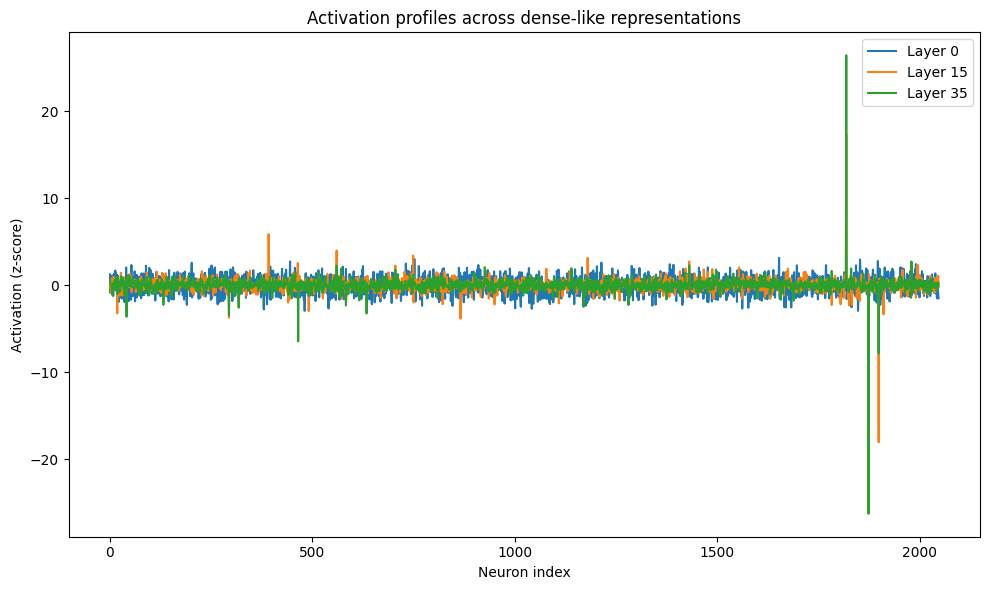

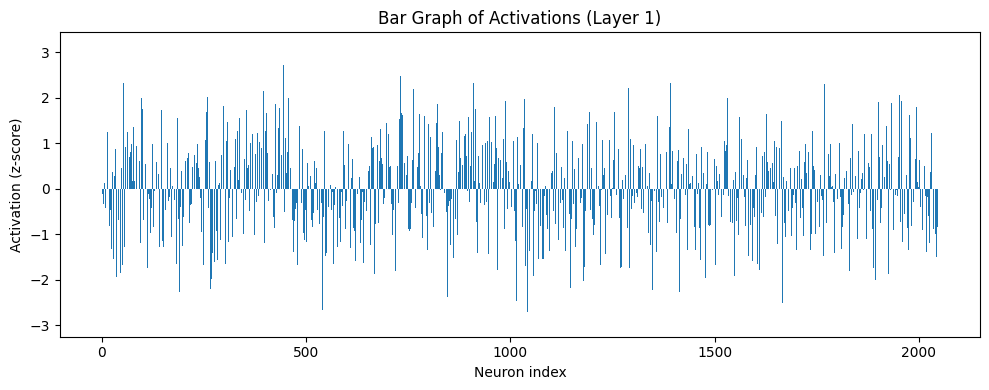

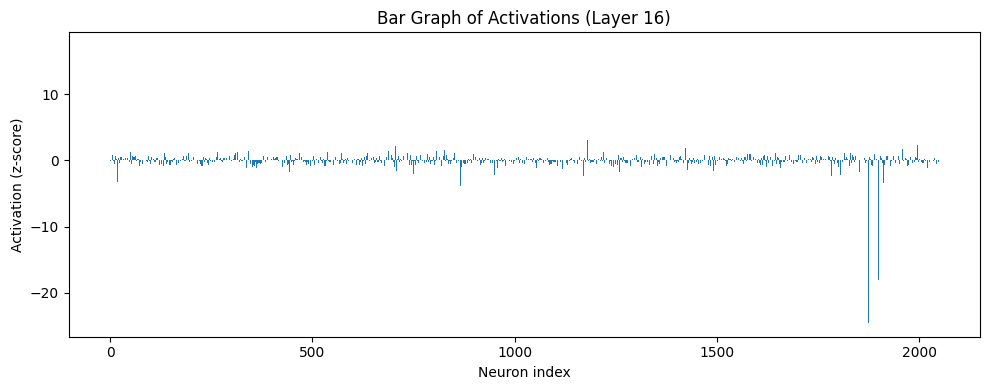

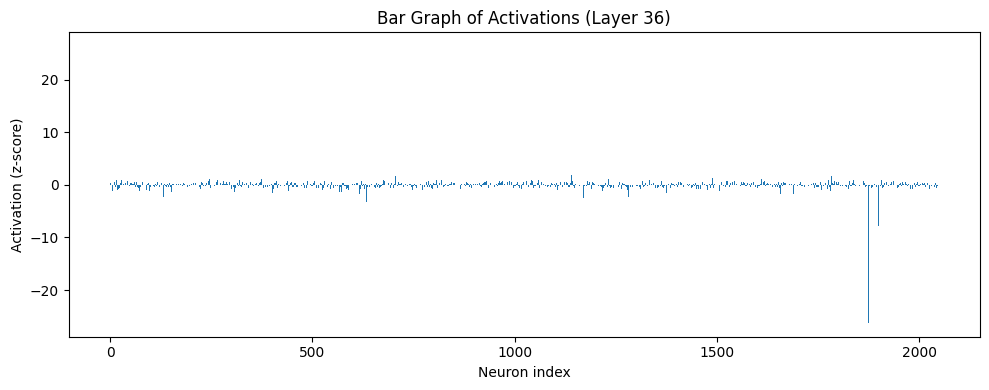

In [ ]:
layers_to_show = [0, 15, 35]  # ตัวอย่าง 3 เลเยอร์
fig, axes = plt.subplots(len(layers_to_show) + 1, 1, figsize=(10, 10))  # +1 สำหรับกราฟเส้น

# ─── 1) กราฟเส้นรวม ───
for li in layers_to_show:
    v = hidden_states[li][0, -1].detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)
    axes[0].plot(v, label=f"Layer {li}")
axes[0].set_title("Activation profiles across dense-like representations")
axes[0].set_xlabel("Neuron index")
axes[0].set_ylabel("Activation (z-score)")
axes[0].legend()

# ─── 2) กราฟแท่งของแต่ละเลเยอร์ ───
for k, li in enumerate(layers_to_show, 1):
    v = hidden_states[li][0, -1].detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)
    axes[k].bar(range(len(v)), v)
    axes[k].set_title(f"Bar Graph of Activations (Layer {li + 1})")
    axes[k].set_xlabel("Neuron index")
    axes[k].set_ylabel("Activation (z-score)")

plt.tight_layout()
plt.savefig("Combined_Activation_Plots.png", dpi=300, bbox_inches="tight")
plt.show()
layers_to_show = [0, 15, 35]  # ตัวอย่าง 3 เลเยอร์
fig, axes = plt.subplots(len(layers_to_show) + 1, 1, figsize=(10, 10))  # +1 สำหรับกราฟเส้น

# ─── 1) กราฟเส้นรวม ───
for li in layers_to_show:
    v = hidden_states[li][0, -1].detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)
    axes[0].plot(v, label=f"Layer {li}")
axes[0].set_title("Activation profiles across dense-like representations")
axes[0].set_xlabel("Neuron index")
axes[0].set_ylabel("Activation (z-score)")
axes[0].legend()

# ─── 2) กราฟแท่งของแต่ละเลเยอร์ ───
for k, li in enumerate(layers_to_show, 1):
    v = hidden_states[li][0, -1].detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)
    axes[k].bar(range(len(v)), v)
    axes[k].set_title(f"Bar Graph of Activations (Layer {li + 1})")
    axes[k].set_xlabel("Neuron index")
    axes[k].set_ylabel("Activation (z-score)")

plt.tight_layout()
plt.savefig("Combined_Activation_Plots.png", dpi=300, bbox_inches="tight")
plt.show()